# Analysis of Finite M/G/1-S Waiting Queue using Power Method
A finite capacity queue is analyzed. Arrivals follow a Poisson process with rate $\lambda$, i.e. $A \sim Exp(\lambda)$. The service times follow a general continuous distribution $B$ with cumulative distribution function $B(t)$ and probability density function $b(t)$. The system has one service unit. The waiting room is limited and there are $S$ waiting places in total. Hence, the total system capacity is $S+1$ and finite.

For the analysis of the steady state distributions, the method of embedded Markov chain is used. The Markov chain is embedded immediately after the departure of a customer. The state probabilities at the embedding times are derived with the power method by iteratively computing the state probabilities $X_n$ at the $n$-th embedding time instant and using the transition probability matrix $\mathcal{P}$. The vector $X_n = \left(x_n(0), x_n(1), \dots, x_n(S)\right)$ represents the state probabilities at the $n$-th embedding time instant. The system is initialized with a start condition $X_0$, e.g., the empty system is $X_0 = (1, 0, \dots, 0)$. Then, the iteration is compactly denoted as $X_{n+1} = X_n \cdot \mathcal{P}$. The power method iterates as long as a stop condition is not fulfilled, $f(X_n, X{n+1})<\epsilon$. A simple, but in practice often sufficiently accurate stop condition is the difference of the means, $f(X_n, X_{n+1}) = \left|E[X_{n}]-E[X_{n+1}]\right|<\epsilon$.

## Transition probability matrix $\mathcal{P}$
The transition probability matrix $\mathcal{P}$ is the key for the analysis using the power method. The finite transition matrix contains the elements $p_{i,j}$ with $i,j = 0,1, \dots S$. Thereby, $p_{ij}$ denotes the transition probabilities for this Markov chain at the embedded time instants. 
$$
p_{ij}=P(X_{n+1}=j|X_n=i)
$$
The transition probabilities depend on the distribution $\Gamma$ of the number of jobs arriving durch a service time of length $B$. The $p_{ij}$ will be derived in the next paragraph.
It is worth to mention that the maximum number of jobs in the system is $S$ (and not $S+1$), since the embedding time instants are immediately after a departure of a job.

$$
\mathcal{P} = \{ p_{ij} \} = \left(\begin{array}{lllll} 
\gamma(0) & \gamma(1) & \gamma(2) & \cdots & 1-\sum_{i=0}^{S-1} \gamma(i)  \\ 
\gamma(0) & \gamma(1) & \gamma(2) & \cdots & 1-\sum_{i=0}^{S-1} \gamma(i)  \\ 
0 & \gamma(0) & \gamma(1)  & \cdots & 1-\sum_{i=0}^{S-2} \gamma(i)  \\ 
0 & 0 & \gamma(0) &  \cdots & 1-\sum_{i=0}^{S-3} \gamma(i)  \\ 
\vdots & \vdots & \vdots & & \vdots \\ 
0 & 0 & \cdots & \gamma(0) & 1-\gamma(0)  \\ 
\end{array}\right)
$$

### Number of arrivals during service time
The random variable $\Gamma$ reflects the number of arrivals during a single service time $B$. The probability is $\gamma(i)=P(\Gamma=i)$ for $i=0,1,\dots$ with the PDF $b(t)$ of the service time.
$$
\gamma(i) = \int_0^\infty \frac{e^{-\lambda t}(\lambda t)^i}{i!}b(t) dt
$$
We derive the probability $\gamma(i)$ numerically using `scipy.integrate`. The PDF of the service time $b(t)=\mu e^{-\mu t}$ (for which we know exact analytical solutions).

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from scipy.integrate import quad
import pandas as pd
from scipy.special import factorial

# parameters of the system
S = 3    # number of waiting places
lam = 1.7 # arrival rate
mu = 1.3
print(1/mu)

# numerical derivation of the integral 
i = np.arange(S+1)
gamma_i = poisson.pmf(i, lam/mu) # lambda * E[B]

print(gamma_i)

0.7692307692307692
[0.27044344 0.3536568  0.23123714 0.10079568]


### Definition of the transition matrix
Now, the transition probability matrix $\mathcal{P}$ can be instantiated. It happens easily that errors are introduced when defining the matrix. Therefore, it is strongly recommended to double check the correct definition and calculation of the elements of the matrix. The matrix is printed and visualized.

          0         1         2         3
0  0.270443  0.353657  0.231237  0.144663
1  0.270443  0.353657  0.231237  0.144663
2  0.000000  0.270443  0.353657  0.375900
3  0.000000  0.000000  0.270443  0.729557


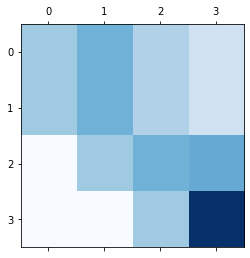

In [5]:
P = np.zeros((S+1,S+1))
for row in np.arange(len(P)):
    for col in np.arange(max(0,row-1), len(P)):
        if col==S:
            P[row,col] = 1-np.sum(P[row,:col])            
        else:
            if row==0:
                P[0,col] = gamma_i[col]
            else:
                P[row,col] = gamma_i[col-row+1]

                # Print and visualize the transition matrix P
print(pd.DataFrame(P)) # pretty display of the matrix using Pandas
plt.figure(1)
plt.clf()
plt.matshow(P,fignum=1, cmap='Blues');

## Power method
The system is initialized with an empty system through proper definition of $X_0$. Then the iteration is conducted for several times and the resulting state probabilities at the embedding time instants are depicted.

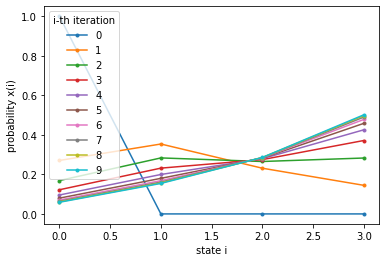

In [9]:
#%% Power Method
# initialize system
num_iter = 10 # number of iterations
X = np.zeros((S+1,num_iter))
X[0,0] = 1 
# iterate
for i in np.arange(1,num_iter):
    X[:,i] = X[:,i-1] @ P # matrix mulitplication

#%% Plot state probabilities
for i in range(num_iter):
    plt.plot(X[:,i],'.-', label=i)
plt.xlabel('state i')
plt.ylabel('probability x(i)')
plt.legend(title='i-th iteration');

### Stop condition of the power method
Now, the iteration is continued until a certail stop condition is fulfilled. Typical examples for stop conditions are as follows.
* difference of means: $\left|E[X_{n+1}] - E[X_{n}] \, \right| < \epsilon$
* difference of standard deviations: $\left|Std[X_{n+1}] - Std[X_{n}] \, \right| < \epsilon$
* or combinations of means and standard deviations, or ...

In [4]:
#%% Definition of stop functions
def stopFunction_mean(X1, X_old, epsilon=1e-6):
    EX_old = X_old @ np.arange(S+1)  # first moment
    EX1 = X1 @ np.arange(S+1)
    return abs(EX_old-EX1) > epsilon 

def stopFunction_std(X1, X_old, epsilon=1e-6):
    EX_old = X_old @ np.arange(S+1)  # first moment
    EX_old_2 = X_old @ np.arange(S+1)**2  # second moment
    std_X_old = np.sqrt(EX_old_2 - EX_old**2)
    
    EX1 = X1 @ np.arange(S+1)
    EX1_2 = X1 @ np.arange(S+1)**2
    std_X1 = np.sqrt(EX1_2 - EX1**2)
    
    return abs(std_X_old-std_X1) > epsilon #or abs(EX_old-EX1) > epsilon 

### Implemenation of the power method
The implemenation of the power method is straightforward. It requires the start condition $X_0$ and the transition matrix $\mathcal{P}$ as well as a stopping condition.

In [5]:
def powerMethod(X0, P, stopFunction):
    X_old = np.zeros(S+1)
    X1 = X0
    epsilon = 1e-3
    num = 0
    while stopFunction(X1, X_old, epsilon) or num<5: # at least 5 iterations
        X_old = X1
        X1 = X_old @ P # matrix mulitplication        
        num +=1
    return X1, num

### Example for different stop conditions
Two different stop conditions are used and the resulting system state probabilities at embedding time instants are plotted.

Mean: 65 iterations
Std: 62 iterations


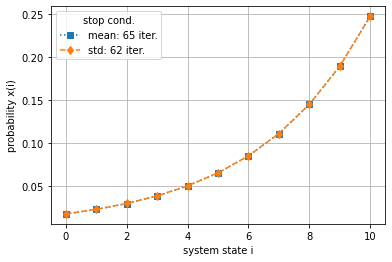

In [6]:
# call the power method
X0 = X[:,0] # start condition

X1, num1 =  powerMethod(X0, P, stopFunction_mean)
print(f'Mean: {num1} iterations')    

X2, num2 =  powerMethod(X0, P, stopFunction_std)
print(f'Std: {num2} iterations')       

# compare the results
plt.plot(X1,'s:', label=f'mean: {num1} iter.')
plt.plot(X2,'d--', label=f'std: {num2} iter.')
plt.xlabel('system state i')
plt.ylabel('probability x(i)')
plt.legend(title='stop cond.')
plt.grid(which='major')

## Computing the system state distribution as Eigenvector of the transition probability matrix
Python also offers numerical methods to compute the Eigenvector. In the steady state, the probability distribution of the system state $X$ is the Eigenvector of the transition probability matrix $\mathcal{P}$ with respect to the Eigenvalue 1. 
$$ X = X \cdot \mathcal{P}$$

In [51]:
from scipy import linalg
eigenvalue, X3 = linalg.eig(P, left=True, right=False) # normalized left eigenvector
i = np.abs(eigenvalue.real-1)<1e-10
print(eigenvalue.real)
print(X3[i].real)


[-4.28166502e-04 -4.28166502e-04  1.40996279e-04  1.40996279e-04
  5.74344726e-04  1.98934465e-02  1.69501728e-01  4.21218713e-01
  6.95126040e-01  1.00000000e+00  9.04260068e-01]
[[-1.05664191e-13 -1.05664191e-13  9.47096991e-14  9.47096991e-14
   2.18551312e-13  4.08139048e-08 -6.88519102e-04  3.93551873e-02
  -2.46875707e-01 -4.93435890e-01  4.39922792e-01]]


## State distribution at arbitrary time instants

The embedding time instants are immediately after departure of customers. The derivation of the steady state distribution at arbitrary time instants is described in Shortle et al. (2018).

$$x^*(i) = \frac{x(i)}{x(0)+\rho} \text{ with } \rho={\lambda}E[B]$$

Shortle, John F.; Thompson, James M.; Gross, Donald; Harris, Carl M.. Fundamentals of Queueing Theory (Wiley Series in Probability and Statistics). Wiley. (2018)

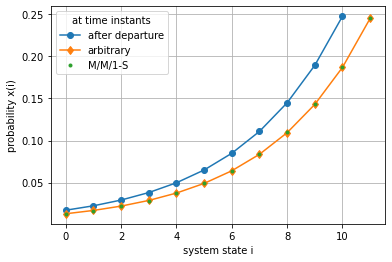

In [7]:
def int_term(t):
    return t*pdf_b(t)

EB = quad(int_term, 0, np.inf)[0] # E[B]=1/mu
rho = lam*EB
X_star = X1/(X1[0]+rho)
X_star = np.append(X_star, 1-X_star.sum())

plt.plot(X1,'o-', label='after departure');
plt.plot(X_star,'d-', label='arbitrary');

# Analytical solution for M/M/1-S
prob = np.zeros(S+2)
a = lam/mu
i = np.arange(1,S+2)
prob[0] = 1/(1+ np.sum(a**i))
prob[i] = a**i * prob[0]

plt.plot(prob,'.', label='M/M/1-S')

plt.xlabel('system state i')
plt.ylabel('probability x(i)')
plt.legend(title='at time instants')
plt.grid(which='major')